In [68]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

In [69]:
with open('order_dict.json') as f:
    data = json.load(f)

In [70]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [71]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [72]:
# def r2_loss(outputs, targets):
#     target_mean = torch.mean(targets)
#     ss_tot = torch.sum((targets - target_mean) ** 2)
#     ss_res = torch.sum((targets - outputs) ** 2)
#     r2 = 1 - ss_res / ss_tot
#     return r2

# def r2_loss_2(outputs, targets):
#     ss_tot = 0.0
#     ss_res = 0.0
#     target_mean = torch.mean(targets)
#     for i in range(0,len(outputs)):
#         ss_tot += (targets[i] - target_mean) ** 2
#         ss_res += (targets[i] - outputs[i]) ** 2
#     r2 = 1 - ss_res / ss_tot
#     return r2

def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = 1000.0 / 31
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    # print("d_pred", d_pred)
    # print("d_actual", d_actual)
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
      mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    # print("spo_loss", spo_loss)
    # print("mse_loss", mse_loss)
    return spo_loss + 0.01 * mse_loss

# print(torch.Tensor.float(1.0))
# outputs = torch.randn(5)
# targets = torch.randn(5)
outputs = torch.tensor([1,2,3,4,6])
targets = torch.tensor([[1],[2],[3],[4],[5]])
# print(outputs.size())
# print(r2_loss(outputs,targets))
# print(r2_loss_2(outputs,targets))
print(SPOLoss(outputs,targets))
print(SPO_MSE_Loss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor([2.9200])
tensor([2.9220])


In [73]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [74]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(epochs),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))
        # print('Train SPO MSE weighted Loss =', SPO_MSE_Loss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    SPO_MSE = SPO_MSE_Loss(y_pred, y_true)
    SPO_MSE_mean = SPO_MSE / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    # return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO Loss Ave': SPO_mean})
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO_Loss': SPO, 'SPO_Loss_Per_Ord': SPO_mean, 'SPO_MSE_Weighted_Loss': SPO_MSE, 'SPO_MSE_Weighted_Loss_Per_Org': SPO_MSE_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [75]:
import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 501
        grid = np.linspace(0,0.5,11) if regularize == 'l2' else np.linspace(0,1,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 301
        grid = np.linspace(3,4,6) if regularize == 'l2' else np.linspace(10,20,5)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(list(aveloss.keys()), list(aveloss.values()))
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    print('The best penalty coefficient is '+ str(best))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    return best

In [76]:
x_train, y_train, x_test, y_test = preprocessing(order_dict[1])

In [77]:
# cross_validate(x_train, y_train, 'MSE', 'l2')

In [78]:
# cross_validate(x_train, y_train, 'MSE', 'l1')

In [79]:
# cross_validate(x_train, y_train, 'SPO', 'l2')

In [80]:
# cross_validate(x_train, y_train, 'SPO', 'l1')

## MSE loss models

### MSE loss model training

model trained using MSE loss
y-intercept  14.353525161743164
Coefficients  [[-0.49050462 -0.04508597 -0.15063877  0.43148172  1.3189306   0.20163599
  -0.9979191  -0.40318707  0.8241011   0.25961825  2.0793772   5.218711
  -0.5330431   0.31821898  6.0018826   0.10092872  1.1821296  -1.442014
  -1.8674672   5.3967967   3.6613004   2.3706427   6.234059   -6.4849725
  -0.5620101   2.726621    0.03479535  0.7196077   0.3535962  -0.0497591
   0.40942386  2.213995    0.69436985 -0.43660837 -0.36627713]]
Train MSE = 58.00489016425516
Train R^2 = 0.7638939080695674
Train SPO Loss = [2051.4820433]


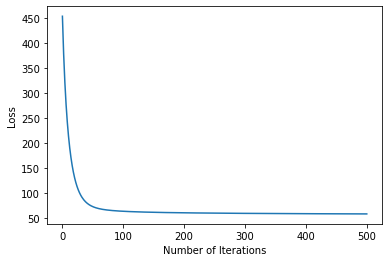

In [81]:
# ols model training

learningRate = 0.02
epochs = 501

model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None')

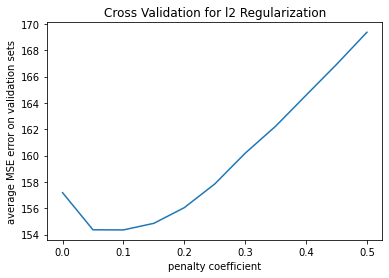

The best penalty coefficient is 0.1
Time:  9.496022680000124
model trained using MSE loss
y-intercept  13.670024871826172
Coefficients  [[-4.1444629e-01  3.4706716e-03 -1.6016550e-01  3.0986109e-01
   8.2095122e-01  2.7416840e-01 -5.5253500e-01 -5.9969926e-01
   9.7070920e-01  9.2946775e-02  1.6466972e+00  3.7647192e+00
  -5.0256371e-01  6.7040962e-01  5.6584530e+00 -1.8877795e-01
   1.3259450e+00 -1.1853000e+00 -1.6603727e+00  5.2030220e+00
   2.8196242e+00  1.8042420e+00  5.9670672e+00 -5.1714764e+00
  -7.7784151e-01  2.3665698e+00 -4.3889601e-02  4.6787900e-01
   1.9197498e-01 -4.1119941e-02  3.4529960e-01  2.1331646e+00
   6.2373585e-01 -4.3151736e-01 -3.7146088e-01]]
Train MSE = 60.24585082675418
Train R^2 = 0.7547721863889609
Train SPO Loss = [1925.9375876]


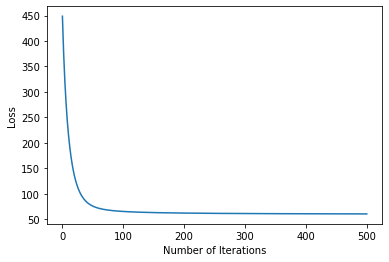

In [82]:
# ridge regression (l2 regrularization)

learningRate = 0.02
epochs = 501

# model training 

best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2')
model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2)

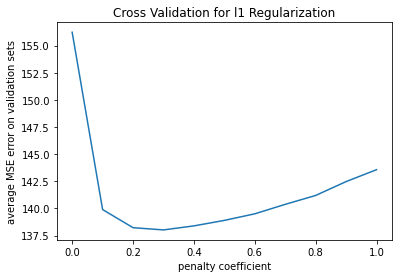

The best penalty coefficient is 0.30000000000000004
Time:  14.209956761000058
model trained using MSE loss
y-intercept  14.35352611541748
Coefficients  [[-1.2343360e-01 -1.4906811e-03 -2.4323885e-03  5.1770027e-04
   2.4428384e-03  1.8218097e-01 -6.2427819e-03 -3.8759214e-01
   1.0856649e+00 -2.4619221e-03  3.7365273e-01  3.8286748e+00
  -4.9751636e-01  4.4280648e-01  6.3854742e+00 -1.4940321e-01
   9.5354170e-01  1.5207855e-03 -7.2214919e-01  5.6925807e+00
   3.0123687e+00  1.7359568e+00  6.3428259e+00 -5.1029830e+00
  -6.2928069e-01  1.9763522e+00 -1.3833205e-02  3.1212571e-01
  -1.7532904e-03  2.0377142e-03  1.9199392e-01  2.0212533e+00
   4.3391770e-01 -2.7392951e-01 -2.2522575e-01]]
Train MSE = 60.59056148762422
Train R^2 = 0.7533690583638184
Train SPO Loss = [2051.01326233]


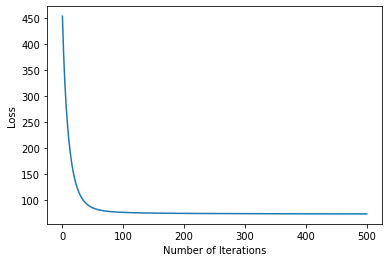

In [83]:
# l1 regularization (lasso) - penalty coefficient set to be 0.1

learningRate = 0.02
epochs = 501

best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1)

### MSE loss model evaluation

In [84]:
# compile results for models trained on MSE loss
MSE_result = []

for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    MSE_result.append(pd.concat({name:score_df}))
    
MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])
MSE_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
mse_ols   train  58.004890  0.763894  2051.482043         10.361020   
          test   65.586901  0.594881   643.584447         11.290955   
mse_ridge train  60.245851  0.754772  1925.937588          9.726958   
          test   61.546802  0.619836   577.829187         10.137354   
mse_lasso train  60.590561  0.753369  2051.013262         10.358653   
          test   59.480591  0.632599   589.535926         10.342736   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Org  
mse_ols   train            2052.062092                      10.363950  
          test              644.240316                      11.302462  
mse_ridge train            1926.540046                       9.730000  
          test              578.444655                      10.148152  
mse_lasso train            2051.619168                      10.361713  
          test              590.130732                      10.353171

## SPO loss models

### SPO loss model training

model trained using SPO loss
y-intercept  8.557989120483398
Coefficients  [[ 2.1594489e-01  3.2885054e-01  4.5401993e-01  1.5107821e-01
   1.1418797e-01  2.6459211e-02  1.3862811e-01  1.0908798e-01
  -4.2265125e-02  3.2472691e-01  1.6317546e+00  2.0309963e+00
   1.5404238e-01  3.0964234e+00  1.8677616e+00 -3.9322984e-01
   2.3409767e+00 -1.0966655e+00 -1.2649809e+00  4.3633084e+00
   3.8156360e-01  1.0917033e+00  1.8233850e+00 -2.4967237e+00
  -2.8889126e-01  8.9580894e-01  2.6909077e-01  4.2935222e-01
  -2.7298506e-02 -5.1644139e-02 -2.4334539e-03  3.0019915e-01
  -1.9642944e-02 -6.3993549e-01 -1.2468616e+00]]
Train MSE = 149.03867590374463
Train R^2 = 0.39334529874165225
Train SPO Loss = [1089.37634606]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


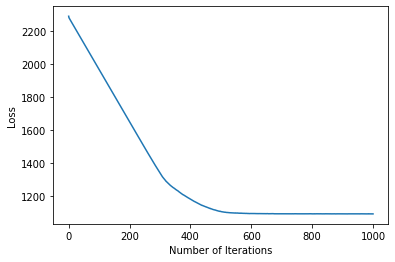

In [85]:
# ols

learningRate = 0.02
epochs = 1001

# model training
model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None')

model trained using SPO loss
y-intercept  8.433656692504883
Coefficients  [[ 2.56828163e-02 -1.43467724e-01  1.71585366e-01  1.85773566e-01
  -1.27794206e-01  3.67179792e-03  2.56276995e-01 -3.87112796e-02
   1.36451125e-01  2.67835595e-02  1.14235699e+00  1.18991697e+00
   8.26913342e-02  2.14687848e+00  1.92420602e+00 -5.20478249e-01
   1.99600518e+00 -7.59631813e-01 -1.16773474e+00  4.16550112e+00
   9.27843988e-01  1.00611305e+00  1.84638608e+00 -1.94946766e+00
  -5.09925485e-01  8.03807795e-01  3.00162137e-01  3.06369692e-01
   1.01662964e-01  1.77662194e-01  1.14803895e-01  3.45841259e-01
   1.81711182e-01 -5.30670643e-01 -8.66965294e-01]]
Train MSE = 154.75277236703275
Train R^2 = 0.37008634624574965
Train SPO Loss = [1109.24760025]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


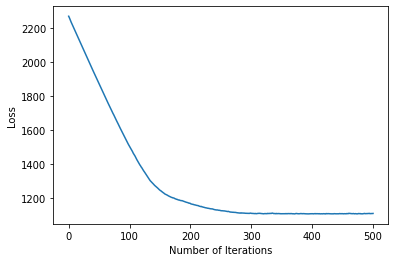

In [86]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = 3.75
model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2_spo)

model trained using SPO loss
y-intercept  8.13053035736084
Coefficients  [[-9.7384723e-03  1.1142661e-02  7.8400653e-03  1.5291733e-01
  -3.4347519e-03  6.0162568e-03  1.3441987e-01 -1.7131848e-03
   4.4630131e-01  2.0573926e-03  1.2666018e-01  5.2435178e-04
  -2.9073013e-03  2.8211641e+00  2.1693337e+00 -3.4751186e-01
   1.4262300e+00  5.8559650e-03 -4.6965933e-01  4.6536131e+00
   7.5298082e-03  1.1431454e-03  3.5575917e-03 -9.4512886e-01
  -3.7529007e-01  1.5660333e-03  2.1675022e-03 -8.0436771e-04
  -2.4454128e-02  1.1036342e-03  2.1608481e-01  3.2639686e-02
   1.5816613e-01 -2.3740484e-01 -2.7656579e-01]]
Train MSE = 191.77769287727733
Train R^2 = 0.2193782031744641
Train SPO Loss = [1186.32428448]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


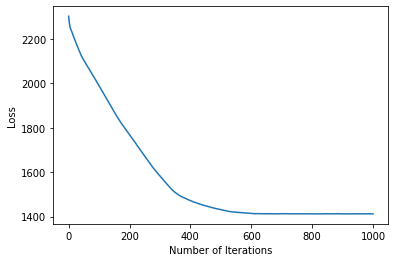

In [87]:
# l1 regularization (lasso)

learningRate = 0.02
epochs = 1001

best_l1_spo = 3.75
model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = 15)

### SPO + 0.01 * MSE weighted loss model training

model trained using SPO_MSE loss
y-intercept  8.56669807434082
Coefficients  [[ 0.217219    0.3211468   0.45963544  0.14525166  0.09866416  0.04196494
   0.14170198  0.10411457 -0.03484003  0.3422234   1.6489058   2.0006125
   0.14738505  3.1293325   1.8652894  -0.38754386  2.337596   -1.1088843
  -1.2748562   4.357669    0.35575563  1.0890163   1.9414401  -2.475956
  -0.27886182  0.89690673  0.27681187  0.4465875  -0.00861141 -0.04998579
  -0.00918265  0.3096332  -0.03482548 -0.6440248  -1.2575506 ]]
Train MSE = 147.92217863700438
Train R^2 = 0.39788994671106603
Train SPO Loss = [1089.45752565]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


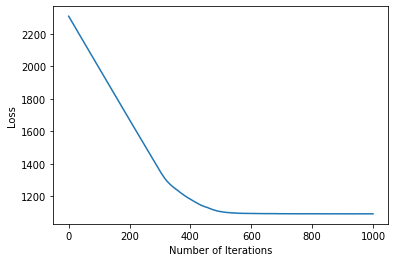

In [88]:
# ols

learningRate = 0.02
epochs = 1001

# model training
model_ols_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE','None')

model trained using SPO_MSE loss
y-intercept  8.437761306762695
Coefficients  [[ 0.00942788 -0.12203151  0.15328023  0.18733901 -0.07520457  0.01574948
   0.23961474 -0.03778108  0.1299394   0.03012451  1.1230414   1.1961608
   0.11043382  2.1811023   1.9170358  -0.54037625  2.0368237  -0.7477478
  -1.1412108   4.2137775   0.91090095  1.0055798   1.8277917  -1.9582485
  -0.5200451   0.82713354  0.27808353  0.29212862  0.1437325   0.17808208
   0.11185303  0.3695556   0.14304923 -0.5264411  -0.8324049 ]]
Train MSE = 154.45440885383866
Train R^2 = 0.37130082045431034
Train SPO Loss = [1108.65993115]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


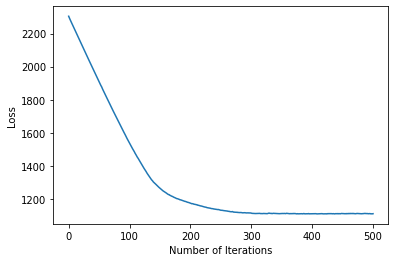

In [89]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = 3.75
model_ridge_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE','l2', l2_penalty = best_l2_spo)

model trained using SPO_MSE loss
y-intercept  8.132057189941406
Coefficients  [[-6.3436935e-03  2.5804150e-03  4.2279824e-03  1.5199505e-01
  -3.9140442e-03  2.2449491e-03  1.2826300e-01 -1.3311277e-02
   4.3817925e-01  1.3927270e-03  1.1851909e-01 -1.7571042e-03
   4.8325141e-04  2.8373358e+00  2.1666532e+00 -3.4389007e-01
   1.4402457e+00  1.0783903e-03 -4.6659994e-01  4.6408324e+00
   9.9039357e-03  2.7142595e-03  1.8793421e-02 -9.4593954e-01
  -3.6690241e-01  3.1202193e-03  2.2238388e-03  4.3332577e-04
  -1.5870651e-02  5.0610793e-04  2.2271736e-01  4.8049595e-02
   1.6928811e-01 -2.2713690e-01 -2.7760160e-01]]
Train MSE = 191.51362484969772
Train R^2 = 0.22045307927230773
Train SPO Loss = [1186.38091594]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


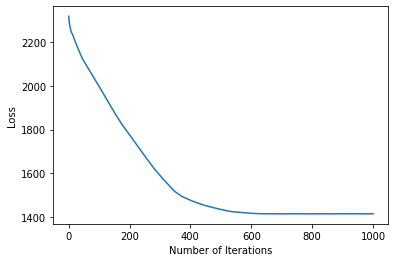

In [90]:
# l1 regularization (lasso)

learningRate = 0.02
epochs = 1001

best_l1_spo = 3.75
model_lasso_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE', 'l1', l1_penalty = 15)

### SPO loss model evaluation

In [91]:
# compile results for models trained on SPO loss
SPO_result = []

for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
spo_ols   train  149.038676  0.393345  1089.376346          5.501901   
          test    98.584245  0.391062   404.569731          7.097715   
spo_ridge train  154.752772  0.370086  1109.247600          5.602261   
          test    99.949615  0.382628   387.282854          6.794436   
spo_lasso train  191.777693  0.219378  1186.324284          5.991537   
          test    98.744723  0.390071   350.930223          6.156671   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Org  
spo_ols   train            1090.866733                       5.509428  
          test              405.555574                       7.115010  
spo_ridge train            1110.795128                       5.610076  
          test              388.282351                       6.811971  
spo_lasso train            1188.242061                       6.001223  
          test              351.917671                       6.173994

In [92]:
# SPO + 0.01 MSE weighted loss
SPO_result = []

for model, name in zip([model_ols_spo_mse, model_ridge_spo_mse, model_lasso_spo_mse],['spo_mse_ols','spo_mse_ridge','spo_mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
spo_mse_ols   train  147.922179  0.397890  1089.457526          5.502311   
              test    98.579672  0.391090   405.605776          7.115891   
spo_mse_ridge train  154.454409  0.371301  1108.659931          5.599293   
              test    99.175922  0.387407   384.441811          6.744593   
spo_mse_lasso train  191.513625  0.220453  1186.380916          5.991823   
              test    98.882556  0.389219   351.368026          6.164351   

                     SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Org  
spo_mse_ols   train            1090.936747                       5.509782  
              test              406.591573                       7.133185  
spo_mse_ridge train            1110.204475                       5.607093  
              test              385.433570                       6.761992  
spo_mse_lasso train            1188.296052                       6.001495  
              test              352.356851                       6.181699

In [93]:
MSE_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
mse_ols   train  58.004890  0.763894  2051.482043         10.361020   
          test   65.586901  0.594881   643.584447         11.290955   
mse_ridge train  60.245851  0.754772  1925.937588          9.726958   
          test   61.546802  0.619836   577.829187         10.137354   
mse_lasso train  60.590561  0.753369  2051.013262         10.358653   
          test   59.480591  0.632599   589.535926         10.342736   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Org  
mse_ols   train            2052.062092                      10.363950  
          test              644.240316                      11.302462  
mse_ridge train            1926.540046                       9.730000  
          test              578.444655                      10.148152  
mse_lasso train            2051.619168                      10.361713  
          test              590.130732                      10.353171

# References

In [94]:
%%script false --no-raise-error
import time
# Batch Gradient Descent Using Numpy - For comparison purpose

"""
code is based on Yuhan Cheng's code, approved use
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = np.zeros((xvalue_matrix.shape[1],))
    epsilon = 0.00001
    n = float(len(xvalue_matrix))
    loss = []
    for i in range(MaxIterations):
        # compute new coefficients
        y_pred = alpha + np.matmul(xvalue_matrix, beta)
        loss.append(mean_squared_error(y_pred,yvalues))
#         if i % 100 == 0:
#             print('Current Loss:', loss)
        d_alpha = np.mean(y_pred - yvalues)
        d_beta = np.mean((y_pred - yvalues) * xvalue_matrix.T, axis = 1)
        alpha_1 = alpha - (R * d_alpha)
        beta_1 = beta - (R * d_beta)
        
        if np.isnan(alpha_1):
            print('nan at iter', str(i))
            break
        
        # check to see whether stopping criteria has been met
        if (np.abs(alpha_1-alpha)<epsilon) and np.all(np.abs(beta_1-beta)<epsilon):
            alpha, beta = alpha_1, beta_1
            print('error < epsilon, criteria met')
            break
        alpha, beta = alpha_1, beta_1
            
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('MSE:', str(loss[-1]))
    print('R2:', str(r2_score(y_true=yvalues, y_pred = y_pred)))
    
    plt.plot(range(len(loss)),loss)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    return alpha, beta

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
